# Анализ использования программного обеспечения КОМПАС-3D. Ноябрь

В настоящее время в АО "МНИИРС" имеется 4 сетевых лицензии ПО КОМПАС-3D. Это означает, что одновременно могут пользоваться 4 сотрудника, при этом если один из сотрудников выключит приложение, его может запустить 5 сотруднико.


**Цель исследования**:
1. Определить количество используемых лицензий по дням пользователями АО "МНИИРС" ПО КОМПАС-3D.
2. Количество активных пользователей ПО КОМПАС-3D.
3. Время использования, загрузки лицензии ПО КОМПАС-3D по пользователям. 


**Ход исследования**

Данные о поведении пользователей получаем из файла с сервера лицензий "SRV-KB" sentinel hasp.

Таким образом, исследование проведем в три этапа:
 1. Обзор данных и предобработка данных.
 2. Расчет использования лицензии по пользователям.
 3. Итоги исследования.

## Обзор данных и предобработка данных

Данные получены из *.log файлов создаваемых платформой ключей защиты Sentinel hasp. Файлы были предобратоны  в excel и скомпонованы для дальнешей обработки.

Импортируем `библиотеки` Python

In [ ]:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sys

Список users получен из *.log файлов. Не все имена на сервере лицензии, совпадают с реальными ФИО пользователей, для этого создадим дублирующий список users_true.

In [ ]:
# задаем пользователей КОМПАС
users = ['Bogdanets@BULYGINA', 'Kopylenkov@KB_KOPYLENKOV', 'ershov_aa@KB_ERSHOV', 'dikin@DIKIN', 'markelova@MARKELOVA', 'kashmov@KASHMOV']
users_true = ['Воронко', 'Копыленков', 'Ершов', 'Дыкин', 'Маркелова', 'Кашмов']

В целом, представленные пользователи в списке users_true, являются активными пользователями ПО КОМПАС-3D.

Далее, требуется обработать *.log файлы, с целью взять в работу только те строки, из которых пользователь обращается или отдает лицензию ПО.

In [ ]:
# запускаем цикл по дате текущего анализа
for date in range(1, 20):
    # читаем Excel таблицу. Log- файл меняем расширение на *.csv, далее открываем через Excel,
    # редактируем заголовки, сохраняем как книгу с расширением *.xlsx
    logs_lodsman = pd.read_excel(f'/content/drive/My Drive/Analysis_KOMPAS_user_duration/data_logs_kompas/2021_11_{date:02d}_access.xlsx')
    # определяем заголовки
    logs_lodsman_columns = logs_lodsman.columns

    # определяем функцию фильтрации таблицы по имени пользователя
    def analise_logs(user):
        global user_time
        # проходим по заголовкам пользователи
        for i in range(len(logs_lodsman_columns)):
            user_time = logs_lodsman[logs_lodsman[logs_lodsman_columns[i]] == user]
            # проверяем, если датафрейм не пустой, то стираем пустые столбы и заканчиваем функцию
            if not user_time.empty:
                user_time = user_time.dropna(axis=1)
                break
        return user_time


    # создаем файлы с именем пользователя c уникальными значениями
    for files in range(len(users)):
        # создаем временный файл с юзером
        analise_logs(users[files]).to_csv(f'/content/drive/My Drive/Analysis_KOMPAS_user_duration/{users[files]}.csv', index=False)
        # читаем временный файл
        user = pd.read_csv(f'/content/drive/My Drive/Analysis_KOMPAS_user_duration/{users[files]}.csv')
        # фильтр по нужным столбцам, заголовкам
        user = user.loc[:, ['time', 'name', 'what']]
        # удаляем дупликаты
        user = user.drop_duplicates().reset_index(drop=True)
        # сохраняем набор данных для анализа по пользователю на одну дату
        user.to_csv(f'/content/drive/My Drive/Analysis_KOMPAS_user_duration/Out/{users[files]}_filtered_{date:02d}_11_2021.csv', index=False)
        # удаляем временный файл с юзером
        #os.remove(os.path.join(os.path.abspath(os.path.dirname(__file__)), f'{users[files]}.csv'))
        # print(user)

##Расчет использования лицензии по пользователям

Определяем функцию для обработки таблиц с данными обращения пользователей на получения и отдачи лицензии ПО КОМПАС-3D.

In [ ]:
def time_long(user, user_true):
    access_long = {} # словарь для хранения данных по продолжительности
    delta_list = [] # список со всеми данными по времени использования
    delta_data = [] # список с датами врмени
    global df_date_duration
    global df_date_duration_count
    for date in range(1, 20):
        # читаем каждый файл с данным по датам
        data_user_lodsman = pd.read_csv(f'/content/drive/My Drive/Analysis_KOMPAS_user_duration/Out/{user}_filtered_{date:02d}_11_2021.csv')
        # задаем начальное время использования компас
        delta = datetime.timedelta(days=0,
                                   seconds=0,
                                   minutes=0,
                                   hours=0)
        # проходим по таблице считая, сколько пользователй использовал нон стоп КОМПАС
        for i in range(len(data_user_lodsman)):
            if data_user_lodsman['what'][i] == '/api/loginex':
                try:
                    delta += pd.to_datetime(data_user_lodsman['time'][i+1]) - pd.to_datetime(data_user_lodsman['time'][i])
                except BaseException:
                    delta += datetime.timedelta(minutes=1)
        # добавляем в списки даты и время использования в минутах
        delta_list.append(delta.total_seconds()/60)
        delta_data.append(f'{date:02d}')

    # добавляем в словарь списки из продолжительности и даты
    access_long['date'] = delta_data
    access_long['duration'] = delta_list

    # получаем датафрейм с датой и продолжнительости
    df_date_duration = pd.DataFrame(access_long)
    #df_date_duration_count = df_date_duration
    #df_date_duration = df_date_duration.loc[[0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 18]]


    # строим график
    sns.barplot(x = df_date_duration['date'], y = df_date_duration['duration'])
    date_duration_sum = round(df_date_duration['duration'].sum(), 1)
    print(f'Сводная информация по пользователю: {user_true}.')
    print(f'Общее время использования КОМПАС-3D: {date_duration_sum} минут, или {round(date_duration_sum / 60, 2)} часов.')
    print(f'\n\n График по дням\n')
    plt.show()

Строим график для пользователя Воронко:

Сводная информация по пользователю: Воронко.
Общее время использования КОМПАС-3D: 1184.1 минут, или 19.74 часов.


 График по дням



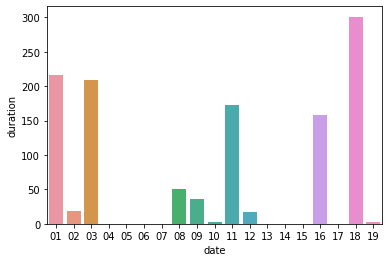

In [ ]:
#вызываем функцию построения графика для пользователя
time_long(users[0], users_true[0])
user_0 = df_date_duration['duration'].loc[[0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 18]]
user_0_count = df_date_duration['duration']

Строим график для пользователя Воронко:

Сводная информация по пользователю: Копыленков.
Общее время использования КОМПАС-3D: 1148.7 минут, или 19.14 часов.


 График по дням



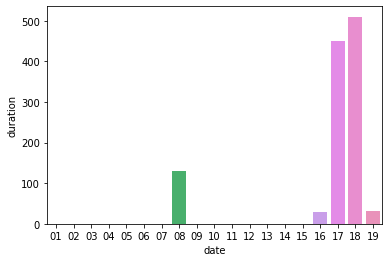

In [ ]:
#вызываем функцию построения графика для пользователя
time_long(users[1], users_true[1])
user_1 = df_date_duration['duration'].loc[[0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 18]]
user_1_count = df_date_duration['duration']

Строим график для пользователя Воронко:

Сводная информация по пользователю: Ершов.
Общее время использования КОМПАС-3D: 2388.3 минут, или 39.8 часов.


 График по дням



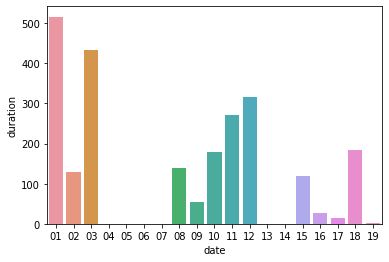

In [ ]:
#вызываем функцию построения графика для пользователя
time_long(users[2], users_true[2])
user_2 = df_date_duration['duration'].loc[[0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 18]]
user_2_count = df_date_duration['duration']

Строим график для пользователя Дыкин:

Сводная информация по пользователю: Дыкин.
Общее время использования КОМПАС-3D: 621.0 минут, или 10.35 часов.


 График по дням



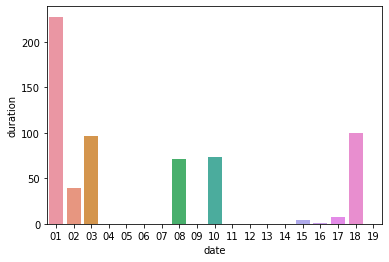

In [ ]:
#вызываем функцию построения графика для пользователя
time_long(users[3], users_true[3])
user_3 = df_date_duration['duration'].loc[[0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 18]]
user_3_count = df_date_duration['duration']

Строим график для пользователя Маркелова:

Сводная информация по пользователю: Маркелова.
Общее время использования КОМПАС-3D: 14.0 минут, или 0.23 часов.


 График по дням



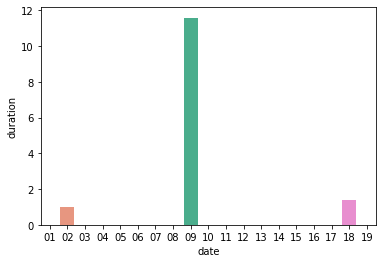

In [ ]:
#вызываем функцию построения графика для пользователя
time_long(users[4], users_true[4])
user_4 = df_date_duration['duration'].loc[[0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 18]]
user_4_count = df_date_duration['duration']

Строим график для пользователя Кашмов:

Сводная информация по пользователю: Кашмов.
Общее время использования КОМПАС-3D: 314.6 минут, или 5.24 часов.


 График по дням



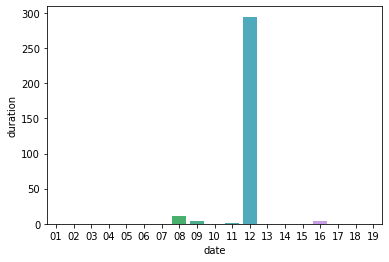

In [ ]:
#вызываем функцию построения графика для пользователя
time_long(users[5], users_true[5])
user_5 = df_date_duration['duration'].loc[[0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 18]]
user_5_count = df_date_duration['duration']

Строим график общего времени использования ПО КОМПАС-3D:

Сводная информация по всем пользователям КОМПАС-3D.
Общее время использования КОМПАС-3D: 5564.2 минут, или 92.74 часов


 График время использования по дням


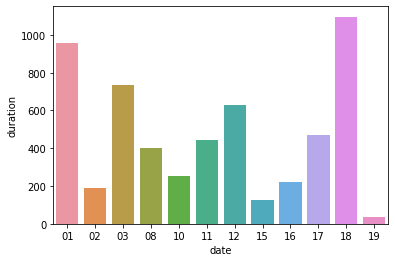

In [ ]:
#строим общий график для всех пользователей. Время использования
data_table = df_date_duration['date']
data_table = data_table.loc[[0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 18]]
sum_all_users = user_0 + user_1 + user_2 + user_3 + user_4 + user_5
table_all_users = pd.concat([data_table,sum_all_users], axis=1)
sns.barplot(x=table_all_users['date'], y=table_all_users['duration'])
date_duration_sum = table_all_users['duration'].sum()
print(f'Сводная информация по всем пользователям КОМПАС-3D.')
print(f'Общее время использования КОМПАС-3D: {round(date_duration_sum, 2)} минут, или {round(date_duration_sum / 60, 2)} часов')
print(f'\n\n График время использования по дням')
plt.show()

Далее, определим количество активных пользователей по дням

In [ ]:
# Определим функцию для изменении даты в "1", т.е. елси пользователь запускал компас на время более, чем 10 минут, мы говорим, что он пользовался КОМПАСОМ
def all_users(users_all):
  
  for i in range(len(list(users_all))):
    if users_all[i] < 10:
      users_all[i] = 0
    else:
      users_all[i] = 1
  users_all.loc[[0, 1, 2, 7, 9, 10, 11, 14, 15, 16, 17, 18]]

In [ ]:
# заменяем данные с даты на 1 для всех пользователей
all_users(user_0_count)
all_users(user_1_count)
all_users(user_2_count)
all_users(user_3_count)
all_users(user_4_count)
all_users(user_5_count)

Строим график количества активных пользователей

Сводная информация по всем пользователям КОМПАС


 График показывающий сколько пользователей пользуются компасом не менее 10 минут



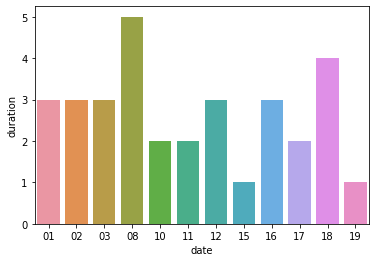

In [ ]:
#строим общий график кол-во пользователей в день
sum_all_users = user_0_count + user_1_count + user_2_count + user_3_count + user_4_count + user_5_count
table_all_users = pd.concat([data_table,sum_all_users], axis=1)
sns.barplot(x=table_all_users['date'], y=table_all_users['duration'])
print(f'Сводная информация по всем пользователям КОМПАС')
print(f'\n\n График показывающий сколько пользователей пользуются компасом не менее 10 минут\n')
plt.show()

Определим медианное и среднее число пользователей ПО КОМПАС-3D

In [ ]:
median_users = table_all_users['duration'].median()
print(f'Медианное число пользователей ПО КОМПАС-3D: {median_users:.02f}')
mean_users = mean_users = table_all_users['duration'].mean()
print(f'Среднее число пользователей ПО КОМПАС-3D: {mean_users:.02f}')

Медианное число пользователей ПО КОМПАС-3D: 2.00
Среднее число пользователей ПО КОМПАС-3D: 1.84


## Итоги исследования


Как мы видим активность пользователей не равномерна. 
Максимальное число активных пользователей: 5 человек.

Медианное число пользователей: 2 человека.
Среднее число пользователей: 1.84 человека.


Исходя из количества пользователей используемых ПО КОМПАС-3D можно сделать вывод, что количество требуемых лицензий: 4 штуки.